### IN THIS NOTEBOOK WE DO INSERTION EXPERIMENTS

In [1]:
import matplotlib.pyplot as plt
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import tensorflow as tf
from basenji import dataset, seqnn, dna_io,stream

import akita_utils
import pysam
import h5py
# genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
print(tf.__version__)


head_i = 1 # mouse
model_num = 0 # which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
    
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2023-02-10 14:55:06.726679: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

### importing background seqs

In [3]:
# background_file = "/home1/kamulege/akita_utils/bin/background_seq_experiments/data/flat_seqs_model3/background_seqs.fa"
# background_file = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/background_seqs.fa"


background_file = "/scratch1/kamulege/shuffled_seqs_human.fa"
background_seqs = []
with open(background_file,'r') as f:
  for line in f.readlines():
    if '>' in line: continue
    background_seqs.append(dna_io.dna_1hot(line.strip())) 

    
len(background_seqs)

5

In [4]:

predictions = seqnn_model.predict(np.array(background_seqs), batch_size=6)


2023-02-10 14:55:11.115701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-10 14:55:11.116086: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2595210000 Hz


In [5]:
predictions.shape

(5, 130305, 6)

In [6]:

def _calculate_scores_from_predictions(predictions):
    scores = []
    scores_pixelwise =[]
    custom_score =[]
    mae = []
    for seq_num in range(predictions.shape[0]):    
        ref_preds=predictions[seq_num,:,:]
        scores_pixelwise += [np.max(ref_preds, axis=0)]
        mae += [np.mean(abs(ref_preds - ref_preds.mean(axis=0)), axis=0)]
        scores += [np.sqrt((ref_preds**2).sum(axis=0))]
        std = np.std(ref_preds, axis=0)
        mean = np.mean(ref_preds, axis=0)
        custom_score +=  [3/mean + 2/std] # remove. this score
        
        print(np.sqrt((ref_preds**2).sum(axis=0)))
        
    return np.max(scores,axis=1), np.max(scores_pixelwise, axis=1), np.min(custom_score,axis=1)


len(_calculate_scores_from_predictions(predictions)[0])

[11.31 13.75 16.03 16.   16.   12.62]
[ 8.    8.   13.92 11.33 11.31 11.31]
[11.31 16.   18.05 16.02 16.   16.  ]
[ 8.   10.04 16.   11.56 11.31 11.31]
[11.31 16.   16.   16.   16.   14.41]


5

### Visualization of the effect of each chosen motif in every available flat background

[11.31 13.75 16.03 16.   16.   12.62] [0.06903 0.11426 0.03004 0.02135 0.03983 0.00425] [27.   22.94 27.38 25.94 24.94 40.38]


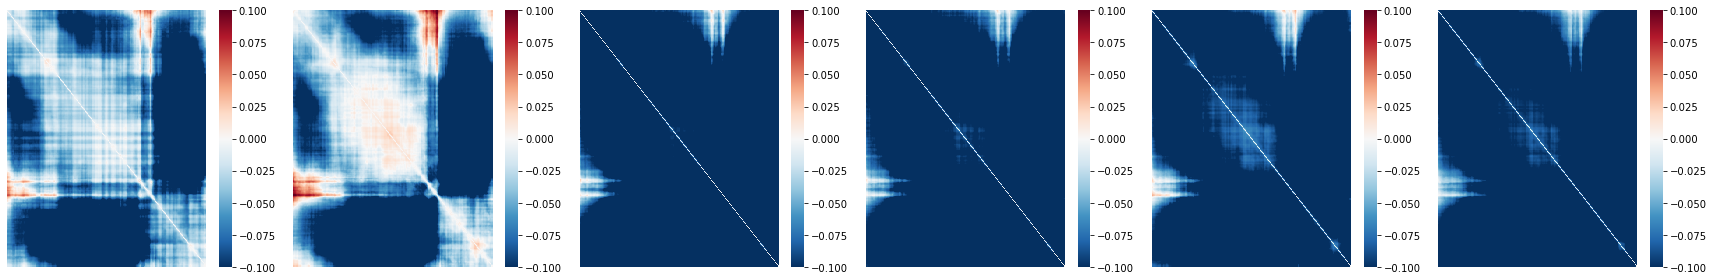

[ 8.    8.   13.92 11.33 11.31 11.31] [ 0.02133  0.04895 -0.08606 -0.08386 -0.06274 -0.0736 ] [51.06 51.9  42.03 44.8  43.44 42.75]


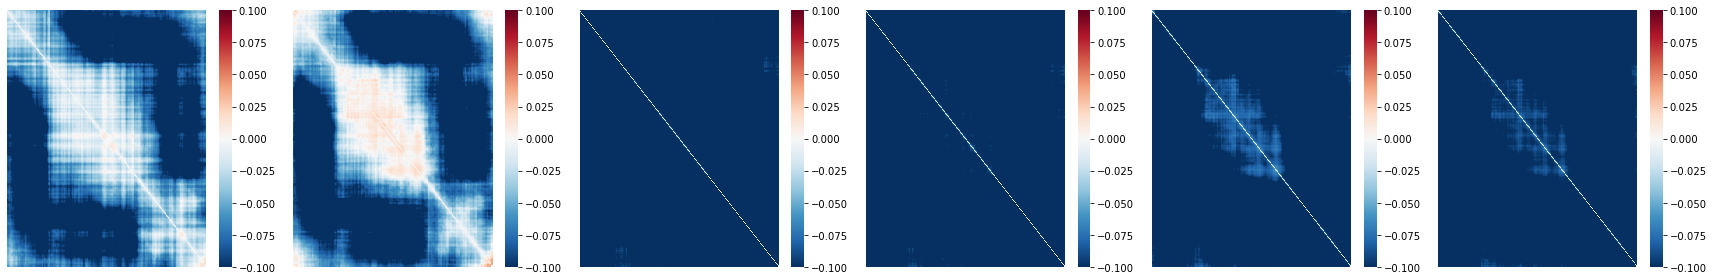

[11.31 16.   18.05 16.02 16.   16.  ] [ 0.1132    0.0579    0.02805   0.006207  0.006012 -0.01559 ] [33.5  24.86 23.84 24.98 24.81 25.95]


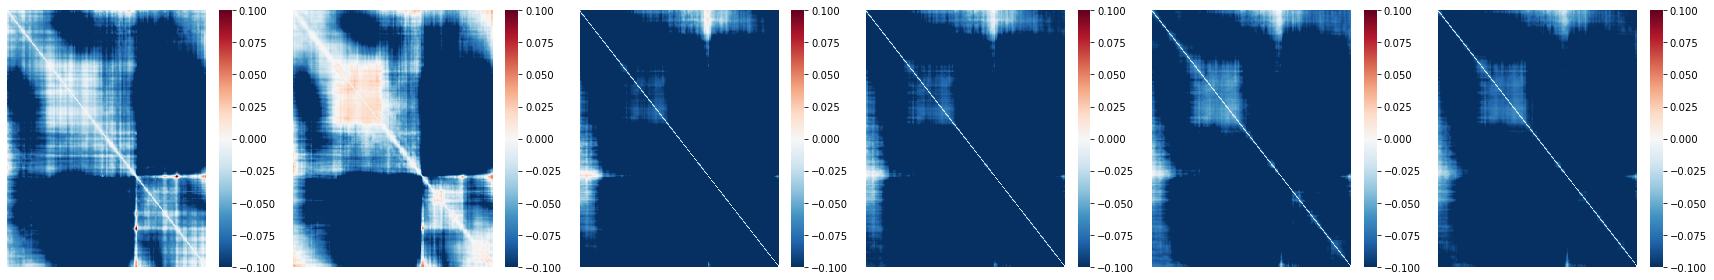

[ 8.   10.04 16.   11.56 11.31 11.31] [ 0.01917  0.04105 -0.05066 -0.05798 -0.0523  -0.06232] [52.44 41.84 33.88 42.25 41.62 41.12]


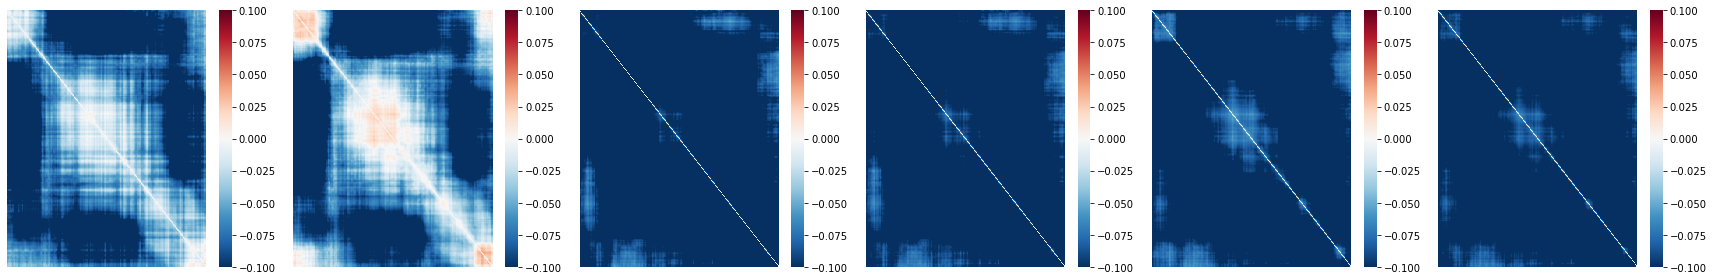

[11.31 16.   16.   16.   16.   14.41] [0.1453  0.1777  0.1235  0.1103  0.1305  0.08325] [24.81  9.31 23.22 22.2  21.27 32.9 ]


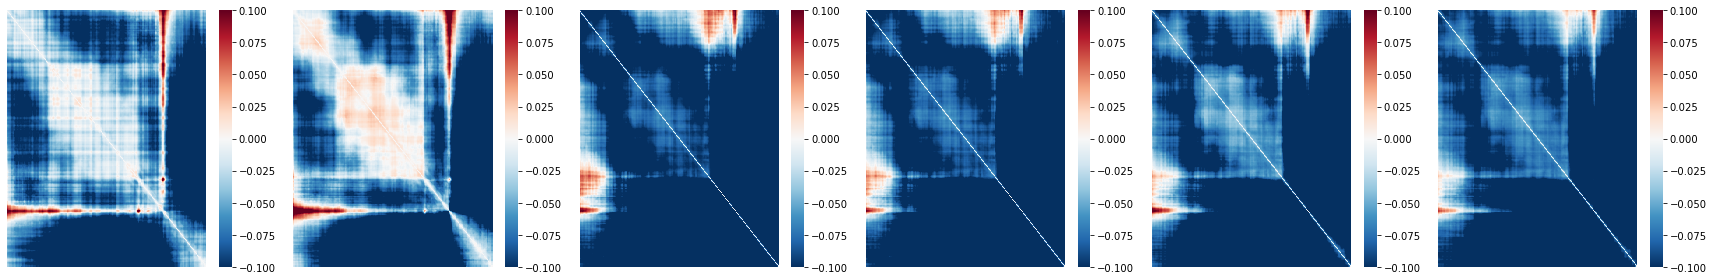

In [7]:
from skimage.measure import block_reduce
import seaborn as sns

for background_seq_num, background_seq in enumerate(background_seqs):
    
    plot_lim_min = 0.1
    ref_preds=predictions[background_seq_num,:,:]
    
    # print(ref_preds.shape)
    sd2_preds = np.sqrt((ref_preds**2).sum(axis=0))
    scores_x = np.sum(ref_preds**2, axis=0)
    
    std = np.std(ref_preds, axis=0)
    mean = np.mean(ref_preds, axis=0)
    scores = np.sum(ref_preds**2, axis=0)

    max_pix = np.amax(ref_preds, axis=0)
    min_pix = np.amin(ref_preds, axis=0)
    
    
    print(sd2_preds,max_pix, 3/mean + 2/std ) # sd2_preds, , 3/mean + 2/std 
    # print(ref_preds.shape)
    ref_map = akita_utils.ut_dense(ref_preds, hic_diags)
    _, axs = plt.subplots(1, ref_preds.shape[-1], figsize=(24, 4))
    for ti in range(ref_preds.shape[-1]):
        ref_map_ti = ref_map[..., ti]
        # TEMP: reduce resolution
        ref_map_ti = block_reduce(ref_map_ti, (2, 2), np.mean)
        # vmin = min(ref_map_ti.min(), ref_map_ti.min())
        # vmax = max(ref_map_ti.max(), ref_map_ti.max())
        # vmin = min(-plot_lim_min, vmin)
        # vmax = max(plot_lim_min, vmax)
        vmin, vmax= -1 * plot_lim_min , plot_lim_min
        sns.heatmap(
            ref_map_ti,
            ax=axs[ti],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cmap="RdBu_r",
            xticklabels=False,
            yticklabels=False,
        )
    plt.tight_layout()
    plt.show()

In [9]:
import numpy as np
from scipy.signal import periodogram
from scipy.stats import kurtosis

def compute_maximum_psd(heatmap):
    # Flatten the heatmap into a 1D array
    data = heatmap.flatten()

    # Compute the periodogram
    f, Pxx_den = periodogram(data)

    # Compute the maximum value of the PSD
    maximum_psd = Pxx_den.max()

    return maximum_psd

def compute_maximum_psd_1d(heatmaps):
    # Apply the compute_maximum_psd function to each 2D slice of the heatmaps array
    maximum_psd_1d = np.apply_along_axis(compute_maximum_psd, axis=0, arr=heatmaps)

    return maximum_psd_1d

def compute_mean_psd(heatmap):
    # Flatten the heatmap into a 1D array
    data = heatmap.flatten()

    # Compute the periodogram
    f, Pxx_den = periodogram(data)

    # Compute the mean value of the PSD
    mean_psd = Pxx_den.mean()

    return mean_psd

def compute_mean_psd_1d(heatmaps):
    # Apply the compute_mean_psd function to each 2D slice of the heatmaps array
    mean_psd_1d = np.apply_along_axis(compute_mean_psd, axis=0, arr=heatmaps)

    return mean_psd_1d


def compute_kurtosis_score(heatmap):
    # Flatten the heatmap into a 1D array
    values = heatmap.flatten()

    # Compute the kurtosis of the distribution of values
    kurtosis_value = kurtosis(values)

    # Compute the kurtosis score as the absolute value of the kurtosis, normalized by the maximum possible absolute kurtosis
    kurtosis_score = np.abs(kurtosis_value) / 3

    return kurtosis_score

def compute_kurtosis_score_1d(heatmaps):
    # Apply the compute_mean_psd function to each 2D slice of the heatmaps array
    compute_kurtosis_score_1d = np.apply_along_axis(compute_kurtosis_score, axis=0, arr=heatmaps)

    return compute_kurtosis_score_1d

def compute_uniformity_score(heatmap):
    # Compute the mean and standard deviation of the values in the map
    mean = np.mean(heatmap)
    std = np.std(heatmap)

    # Compute the coefficient of variation as the standard deviation divided by the mean
    cv = std / mean

    # Compute the uniformity score as the inverse of the coefficient of variation
    uniformity_score = 1 / cv

    return uniformity_score

def compute_uniformity_score_1d(heatmaps):
    # Apply the compute_mean_psd function to each 2D slice of the heatmaps array
    compute_uniformity_score_1d = np.apply_along_axis(compute_uniformity_score, axis=0, arr=heatmaps)

    return compute_uniformity_score_1d

def flatness_measure(matrix, [0.15,0.15]):
  # Count the number of values in the matrix that fall within the desired range
  num_values = np.size(matrix)
  num_flat_values = np.size(np.where(np.abs(matrix) <= range))

  # Return the percentage of values that are within the range
  return num_flat_values / num_values

def flatness_measure(matrix, range):
    # Apply the function to each 2D slice of the heatmaps array
    compute_uniformity_score_1d = np.apply_along_axis(flatness_measure, axis=0, arr=heatmaps)

  # Return the percentage of values that are within the range
  return num_flat_values / num_values

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 92)

In [ ]:
import numpy as np

np.nan == 